In [54]:
from collections import defaultdict

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imageio

## P8.1

In [2]:
def plot_Ck(G):
    degrees = dict(G.degree())
    clustering = nx.clustering(G)

    deg_values = np.array(list(degrees.values()))
    cluster_values = np.array(list(clustering.values()))

    # group by degree
    Ck = {}
    for d, c in zip(deg_values, cluster_values):
        Ck.setdefault(d, []).append(c)

    ks = sorted(Ck.keys())
    C_avg = [np.mean(Ck[k]) for k in ks]

    plt.figure(figsize=(7,5))
    plt.scatter(ks, C_avg)
    plt.xlabel("k")
    plt.ylabel("C(k)")
    plt.title("Degree–Clustering Relation C(k)")
    plt.grid(True)
    plt.show()

## P8.2

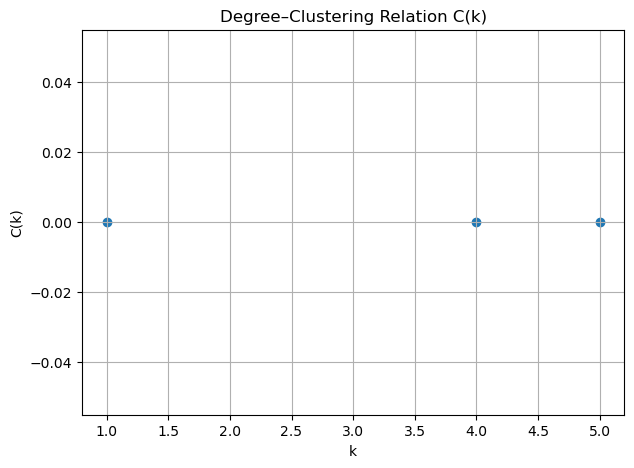

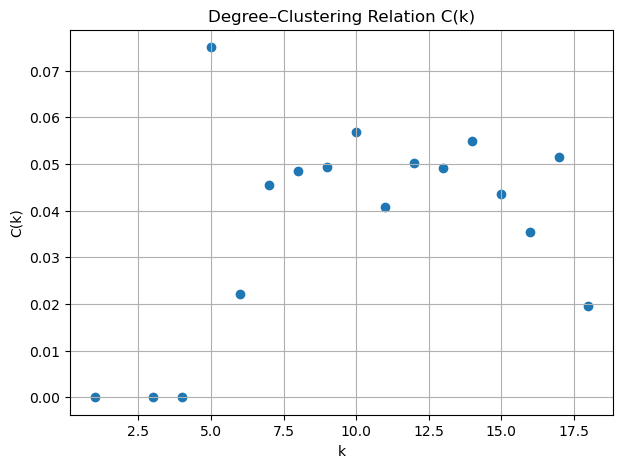

In [4]:
G_hier = nx.balanced_tree(r=4, h=8)

G_rand = nx.erdos_renyi_graph(200, 0.05)

plot_Ck(G_hier)
plot_Ck(G_rand)

## P8.3

In [13]:
def load_gtfs(path):
    stops = pd.read_csv(path + "/stops.txt")
    trips = pd.read_csv(path + "/trips.txt")
    stop_times = pd.read_csv(path + "/stop_times.txt")
    routes = pd.read_csv(path + "/routes.txt")
    return stops, trips, stop_times, routes

def build_layer(stop_times, trips, routes, transport_type):
    if transport_type:
        route_ids = routes[routes['route_type']==transport_type]['route_id']
    else:
        route_ids = routes['route_id']
    trip_ids = trips[trips['route_id'].isin(route_ids)]['trip_id']

    df = stop_times[stop_times['trip_id'].isin(trip_ids)]
    G = nx.Graph()

    for trip_id, group in df.groupby("trip_id"):
        stops_seq = group.sort_values("stop_sequence")['stop_id'].tolist()
        for u, v in zip(stops_seq[:-1], stops_seq[1:]):
            G.add_edge(u, v)

    return G

In [ ]:
path = "ZTM"
stops, trips, stop_times, routes = load_gtfs(path)
G_bus = build_layer(stop_times, trips, routes, transport_type=3)
G_tram = build_layer(stop_times, trips, routes, transport_type=0)

In [14]:
G_skm = build_layer(stop_times, trips, routes, transport_type=2)
G_whole = build_layer(stop_times, trips, routes, transport_type=None)

In [ ]:
# G_total = nx.compose(G_bus, G_tram)
# print(compute_stats(G_total))

## P8.4

In [7]:
def compute_stats(G):
    return {
        "nodes": G.number_of_nodes(),
        "edges": G.number_of_edges(),
        "avg_degree": sum(dict(G.degree()).values()) / G.number_of_nodes(),
        "diameter": nx.diameter(G) if nx.is_connected(G) else None,
        "avg_clustering": nx.average_clustering(G),
        "components": nx.number_connected_components(G)
    }

{'nodes': 6091, 'edges': 8031, 'avg_degree': 2.6370054178295845, 'diameter': 123, 'avg_clustering': 0.02347800050147776, 'components': 1}
{'nodes': 619, 'edges': 757, 'avg_degree': 2.4458804523424877, 'diameter': 48, 'avg_clustering': 0.001992460958535272, 'components': 1}


In [15]:
print(compute_stats(G_bus))
print(compute_stats(G_tram))
print(compute_stats(G_skm))
print(compute_stats(G_whole))

{'nodes': 6091, 'edges': 8031, 'avg_degree': 2.6370054178295845, 'diameter': 123, 'avg_clustering': 0.02347800050147776, 'components': 1}
{'nodes': 619, 'edges': 757, 'avg_degree': 2.4458804523424877, 'diameter': 48, 'avg_clustering': 0.001992460958535272, 'components': 1}
{'nodes': 62, 'edges': 63, 'avg_degree': 2.032258064516129, 'diameter': 26, 'avg_clustering': 0.0, 'components': 1}
{'nodes': 6756, 'edges': 8845, 'avg_degree': 2.618413262285376, 'diameter': None, 'avg_clustering': 0.021334788985765893, 'components': 2}


## P8.5

In [16]:
def draw_geographical(G, stops):
    pos = {
        row.stop_id : (row.stop_lon, row.stop_lat) for _, row in stops.iterrows()
    }

    plt.figure(figsize=(8,8))
    nx.draw(G, pos, node_size=10, linewidths=0.1, edge_color='gray')
    plt.title("ZTM Transport Network – Geo Layout")
    plt.show()

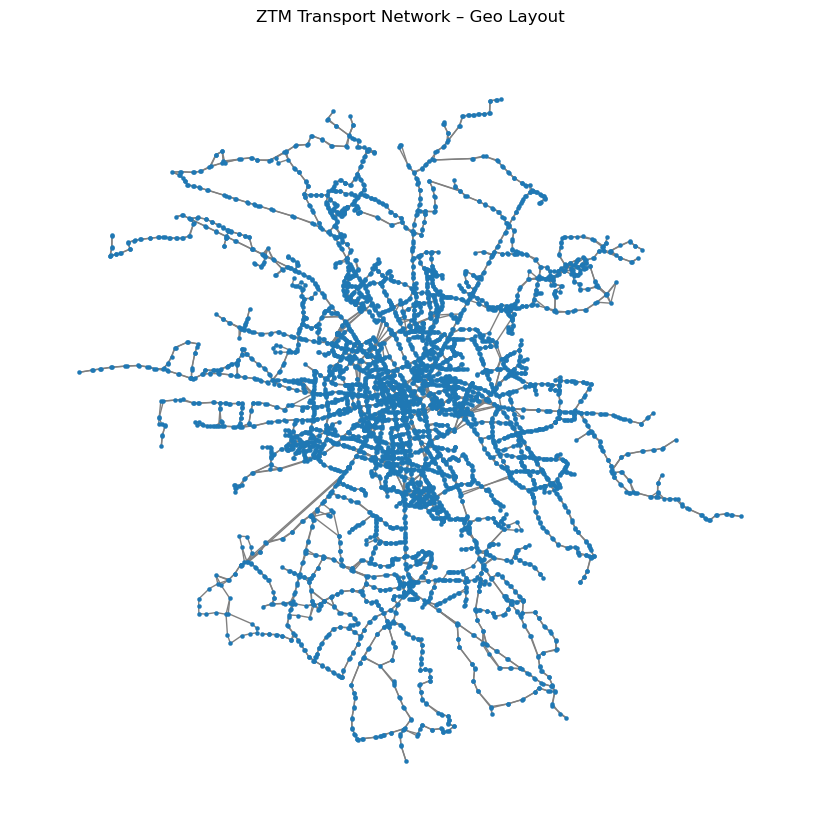

In [17]:
draw_geographical(G_bus, stops)

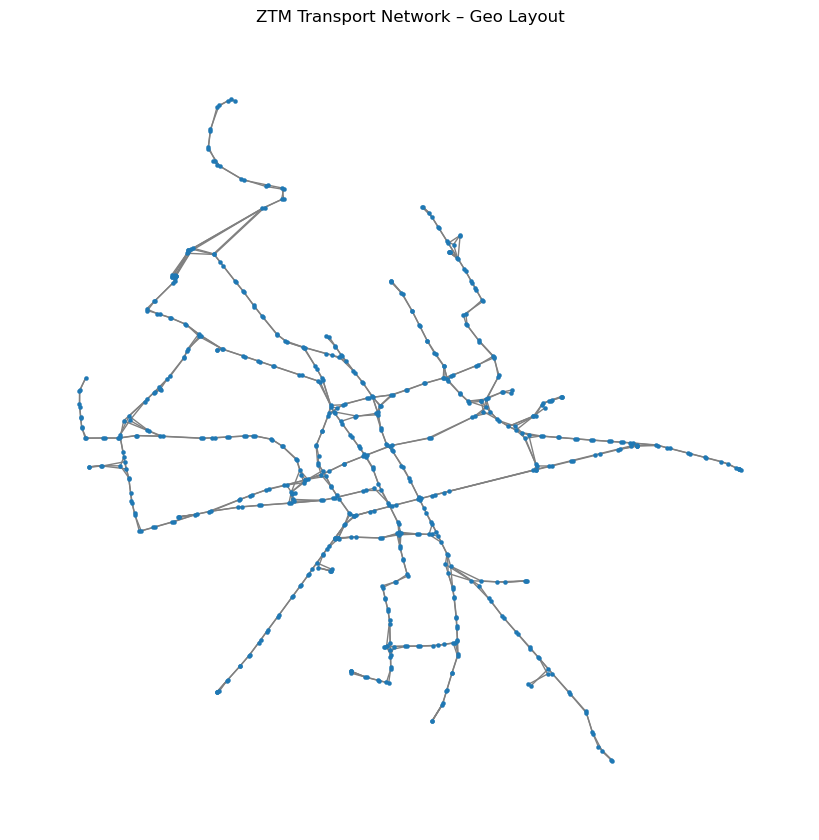

In [18]:
draw_geographical(G_tram, stops)

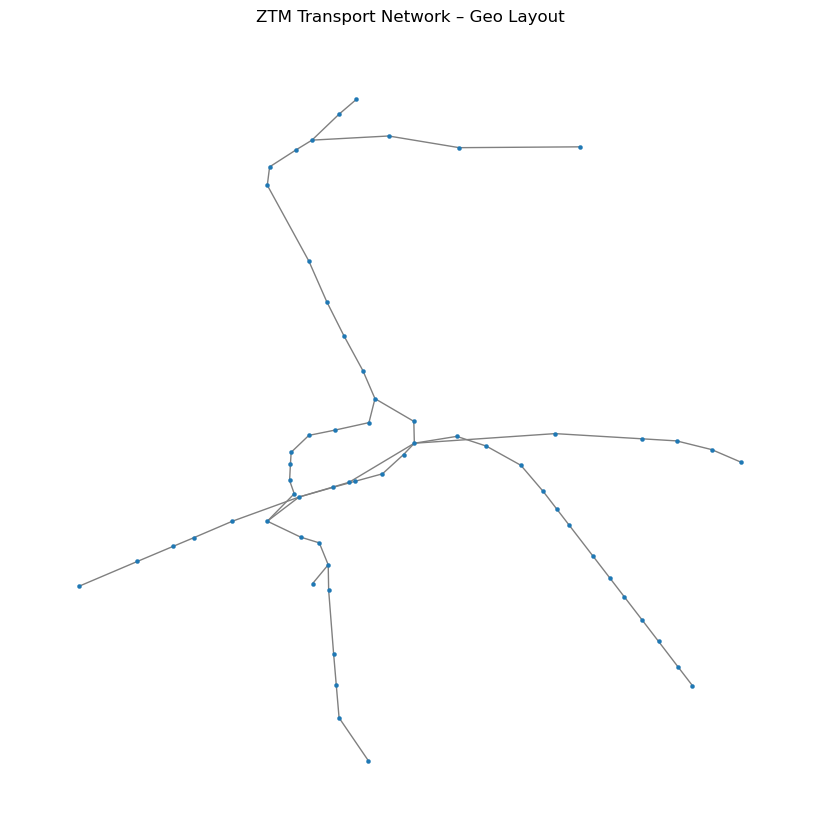

In [19]:
draw_geographical(G_skm, stops)

## P8.6

In [20]:
def temporal_edges(stop_times, trip_ids):
    events = []
    df = stop_times[stop_times["trip_id"].isin(trip_ids)]

    for trip_id, group in df.groupby("trip_id"):
        g = group.sort_values("stop_sequence")
        rows = g[["stop_id", "departure_time"]].values

        for (u, t1), (v, t2) in zip(rows[:-1], rows[1:]):
            events.append({
                "u": u,
                "v": v,
                "t_depart": t1,
                "t_arrive": t2
            })
    return events

In [26]:
bus_route_ids = routes[routes['route_type'] == 3]['route_id']

In [27]:
trip_ids_bus = trips[trips['route_id'].isin(bus_route_ids)]['trip_id']
events_bus = temporal_edges(stop_times, trip_ids_bus)

In [31]:
def draw_temporal_snapshot(events, stops, time_str):
    """
    Draw a graph of all active vehicle connections at a given moment
    """
    minute = time_to_minutes(time_str + ":00")

    # Extract stop coordinates
    pos = {
        row.stop_id: (row.stop_lon, row.stop_lat)
        for _, row in stops.iterrows()
    }

    # Build graph of active edges at the given time
    G = nx.DiGraph()
    active_edges = [
        (e["u"], e["v"]) for e in events
        if time_to_minutes(e["t_depart"]) <= minute <= time_to_minutes(e["t_arrive"])
    ]
    G.add_edges_from(active_edges)

    # Plot
    plt.figure(figsize=(10,10))
    nx.draw_networkx_nodes(G, pos, node_size=6, alpha=0.8)
    nx.draw_networkx_edges(G, pos, edgelist=active_edges, width=1, arrows=False)

    plt.title(f"Temporal Network Snapshot at {time_str}")
    plt.axis("off")
    plt.show()

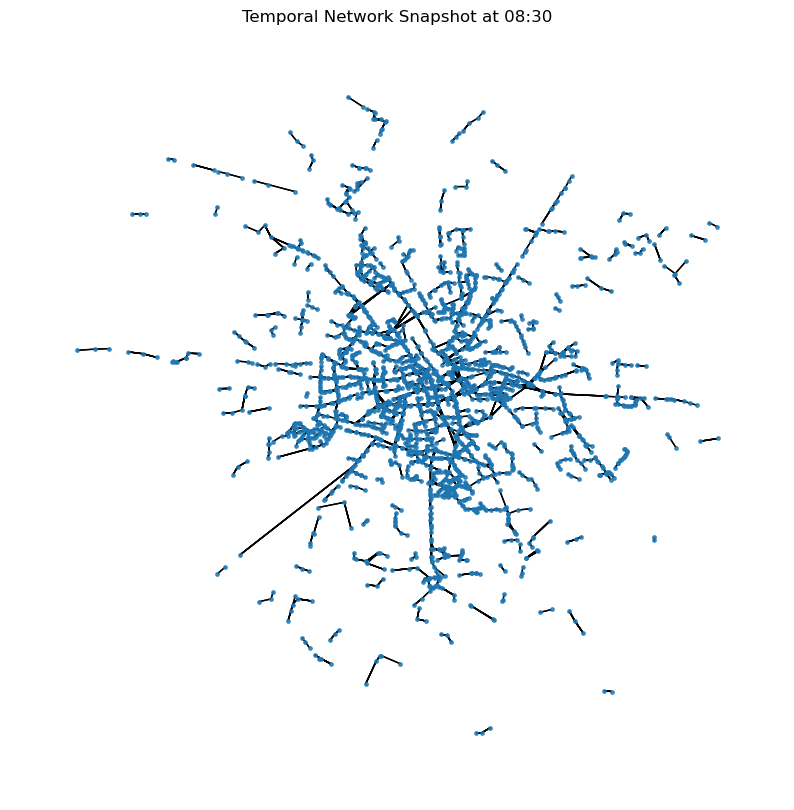

In [32]:
draw_temporal_snapshot(events_bus, stops, "08:30")

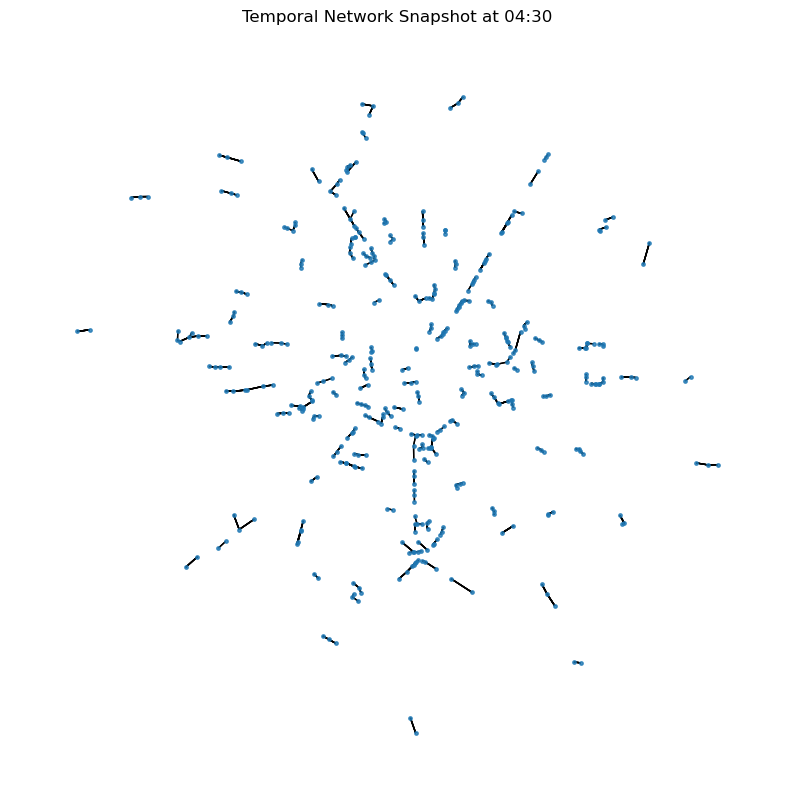

In [37]:
draw_temporal_snapshot(events_bus, stops, "04:30")

## P8.7

In [87]:
def time_to_minutes(t):
    h, m, s = map(int, t.split(":"))
    return h*60 + m

def animate_flow(events, stops, fname="flow.gif"):
    images = []
    G = nx.DiGraph()
    pos = {row.stop_id:(row.stop_lon, row.stop_lat) for _,row in stops.iterrows()}

    for minute in range(0, 24*60, 30):  # every 30 minutes
        active = [(e["u"],e["v"]) for e in events
                  if time_to_minutes(e["t_depart"]) <= minute <= time_to_minutes(e["t_arrive"])]

        plt.figure(figsize=(10,10))
        nx.draw_networkx_nodes(G, pos, node_size=3)
        nx.draw_networkx_edges(G, pos, edgelist=active, width=1)
        plt.title(f"Traffic at {minute//60:02d}:{minute%60:02d}")
        plt.axis("off")
        plt.savefig("frame.png")
        plt.close()
        images.append(imageio.imread("frame.png"))

    imageio.mimsave(fname, images, duration=0.1)

In [ ]:
animate_flow(events_bus, stops, fname="flow2.gif")

C:\Users\agata\AppData\Local\Temp\ipykernel_39904\31636448.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread("frame.png"))


## P8.8

In [33]:
def metric_over_time(events, metric_fn, interval=30):
    timeline = {}

    for minute in range(0, 24*60, interval):
        G = nx.DiGraph()
        active_edges = [(e["u"], e["v"]) for e in events
                        if time_to_minutes(e["t_depart"])<=minute<=time_to_minutes(e["t_arrive"])]
        G.add_edges_from(active_edges)

        timeline[minute] = metric_fn(G)
    return timeline

def plot_metric_time(mt):
    times = list(mt.keys())
    values = list(mt.values())
    plt.plot(times, values)
    plt.xlabel("Minutes")
    plt.ylabel("Metric value")
    plt.title("Metric vs Time")
    plt.grid(True)
    plt.show()

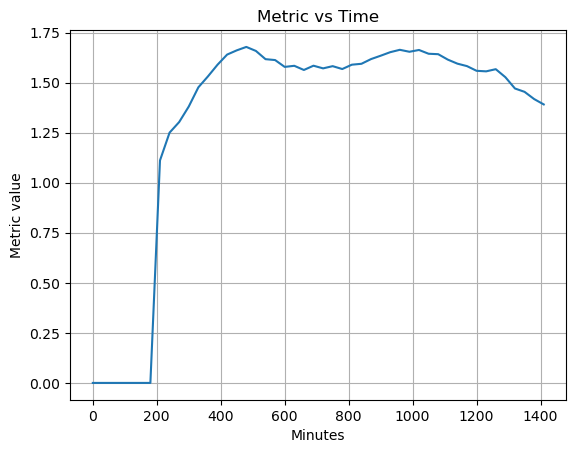

In [34]:
deg_time = metric_over_time(events_bus, stops, lambda G: sum(dict(G.degree()).values())/max(1,G.number_of_nodes()))
plot_metric_time(deg_time)

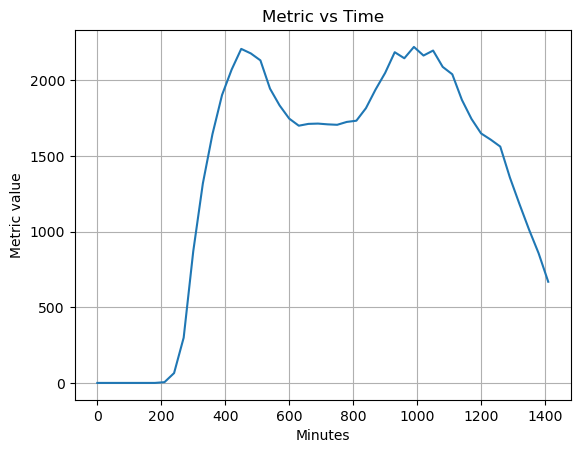

In [38]:
edge_time = metric_over_time(events_bus, stops, lambda G: G.number_of_edges())
plot_metric_time(edge_time)

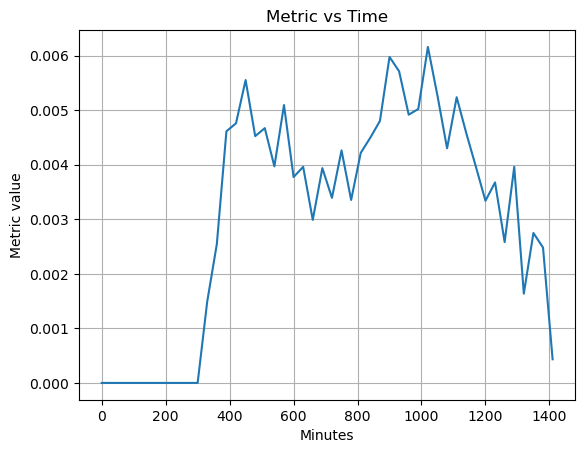

In [44]:
coef_time = metric_over_time(events_bus, stops, lambda G: nx.average_clustering(G) if G.number_of_nodes() > 0 else 0)
plot_metric_time(coef_time)

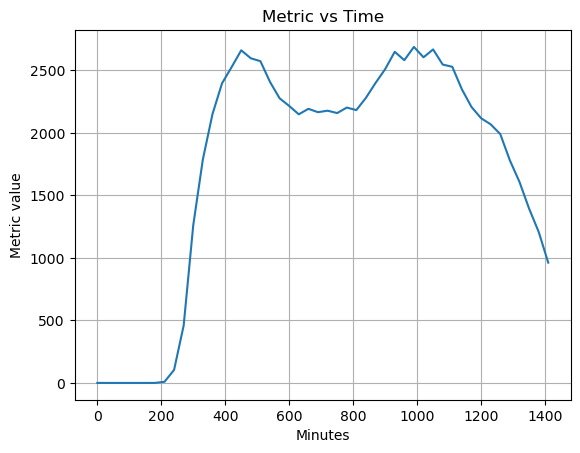

In [48]:
comp_time = metric_over_time(events_bus, stops, lambda G: nx.number_strongly_connected_components(G) if G.number_of_nodes() > 0 else 0)
plot_metric_time(comp_time)

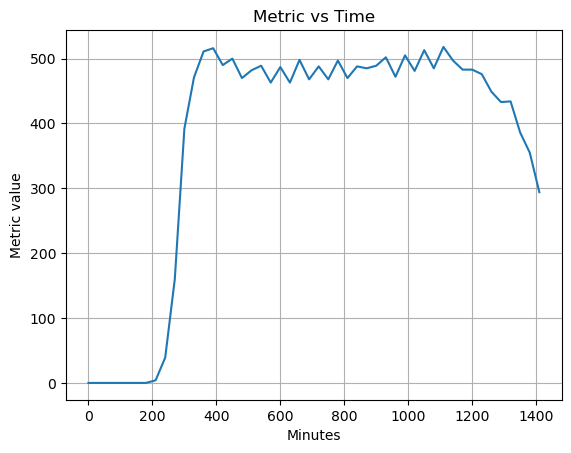

In [49]:
comp_weak_time = metric_over_time(events_bus, stops, lambda G: nx.number_weakly_connected_components(G) if G.number_of_nodes() > 0 else 0)
plot_metric_time(comp_weak_time)

## P8.9

How trip time changes for Uniwersytet Medyczny to Uniwersytet in the day?

In [55]:
def minutes_to_time(m):
    return f"{m//60:02d}:{m%60:02d}"

def index_events_by_stop(events):
    outgoing = defaultdict(list)
    for e in events:
        t_dep = time_to_minutes(e["t_depart"])
        t_arr = time_to_minutes(e["t_arrive"])
        outgoing[e["u"]].append((t_dep, t_arr, e["v"]))
    # sort by departure time for binary search efficiency
    for u in outgoing:
        outgoing[u].sort()
    return outgoing

In [56]:
events_index = index_events_by_stop(events_bus)

In [57]:
import heapq

def earliest_arrival(events_index, start, end, start_time_min):
    """
    Computes earliest arrival from start→end when leaving at start_time_min.
    Returns arrival time in minutes, or None if unreachable.
    """
    pq = [(start_time_min, start)]  # (current time, stop)
    visited = {}                    # stop → best known arrival

    while pq:
        t_curr, u = heapq.heappop(pq)

        # If we reached the destination: done
        if u == end:
            return t_curr

        # If we already visited u with a better time, skip
        if u in visited and visited[u] <= t_curr:
            continue
        visited[u] = t_curr

        # Explore outgoing edges from u
        for t_dep, t_arr, v in events_index.get(u, []):
            if t_dep >= t_curr:
                # Can catch this trip
                heapq.heappush(pq, (t_arr, v))

    return None  # unreachable

In [58]:
def trip_time_over_day(events_index, start, end, interval=10):
    """
    Computes travel time between two stops for each time window of the day.
    Returns: dictionary {minute_of_day : travel_time_minutes or None}
    """
    results = {}

    for minute in range(0, 24*60, interval):
        arrival = earliest_arrival(events_index, start, end, minute)
        if arrival is None:
            results[minute] = None
        else:
            results[minute] = arrival - minute

    return results

In [83]:
start_stop = 155 #154
end_stop = 875#931

trip_profile = trip_time_over_day(events_index, start_stop, end_stop, interval=30)

In [77]:
def plot_trip_time(trip_profile, start, end, start_time=None, end_time=None):
    times = list(trip_profile.keys())
    if end_time is None:
        end_time = max(times)
    if start_time is None:
        start_time = min(times)
    times = times[times.index(start_time):times.index(end_time)]
    values = [
        trip_profile[t] if trip_profile[t] is not None else float("nan")
        for t in times
    ]

    plt.figure(figsize=(10,5))
    plt.plot(times, values, marker="o", linewidth=1)
    plt.xlabel("Minutes of day")
    plt.ylabel("Travel time (min)")
    plt.title(f"Temporal trip time: {start} → {end}")
    plt.grid(True)
    plt.ylim(0)
    plt.show()

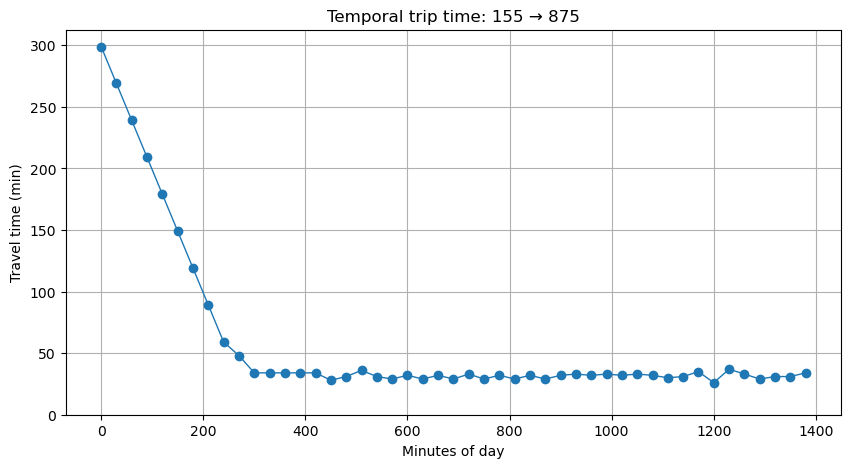

In [84]:
plot_trip_time(trip_profile, start_stop, end_stop)

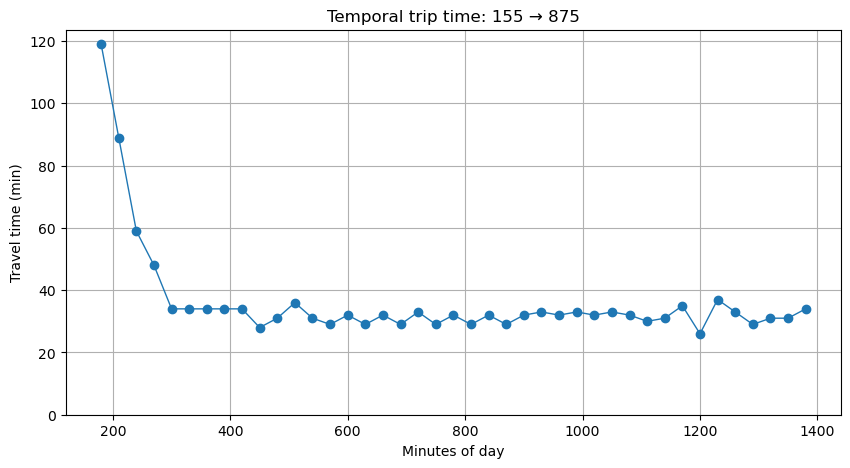

In [86]:
plot_trip_time(trip_profile, start_stop, end_stop, start_time=3*60)